In [4]:
# Imports
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Load the dataframe with all the features we have been able the extract
df_raw = pd.read_csv("all_features.csv")
df_no_AR = pd.read_csv("all_features_no_artifact_removal.csv")

# Iterative improvements

The goal of this notebook is to shiw the improvements we have witnessed along our journey through this group project. 

# First focus: Extracting an increasing amount of features

Let's compare the performance of a Random forest classifier on the following set of features: 
- EEG features only
- EEG + EOG features
- EEG + EOG + ECG features 

In [4]:
# Load create the dataframes decribed above
EEG_col = [col for col in df_no_AR.columns if 'EEG' in col]
EOG_col = [col for col in df_no_AR.columns if 'EOG' in col]
ECG_col = [col for col in df_no_AR.columns if 'ECG' in col]

df1 = df_no_AR.drop(columns=EOG_col + ECG_col)    # Contains only  EEG
df2 = df_no_AR.drop(columns=ECG_col )             # Contains EEG & EOG
df3 = df_no_AR                                    # Contains features from EEG, EOG & ECG

df_list = [df1,df2,df3]
name_list = ['EEG','EEG + EOG', 'EEG + EOG + ECG']

Dropping 8 features with |corr| > 0.95:
['EEG variance', 'EEG std', 'EEG hjorth_activity', 'EEG hjorth_mobility', 'EEG absolute_power alpha', 'EEG absolute_power beta', 'EEG absolute_power gamma', 'EEG relative_power beta']

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.52      0.10      0.17       299
           1       0.81      0.46      0.59       399
           2       0.54      0.86      0.66       789
           3       0.00      0.00      0.00        49
           4       0.78      0.78      0.78       632

    accuracy                           0.64      2168
   macro avg       0.53      0.44      0.44      2168
weighted avg       0.64      0.64      0.60      2168

Accuracy: 0.6379


c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


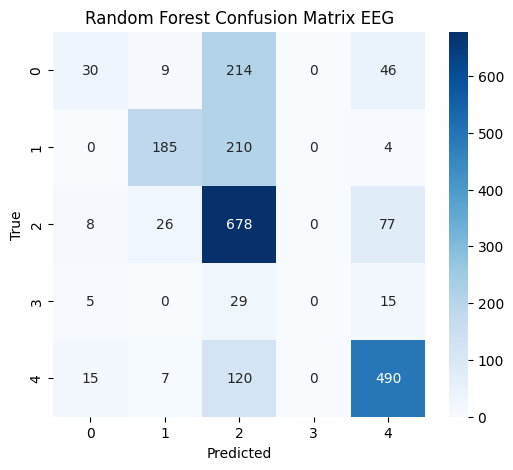

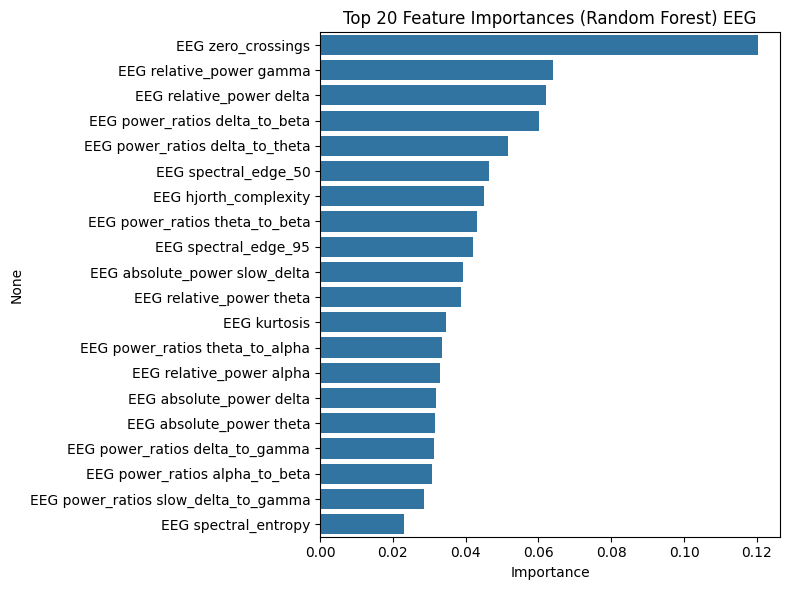

Dropping 16 features with |corr| > 0.95:
['EEG variance', 'EEG std', 'EEG hjorth_activity', 'EEG hjorth_mobility', 'EEG absolute_power alpha', 'EEG absolute_power beta', 'EEG absolute_power gamma', 'EEG relative_power beta', 'EOGL movement_density_mean', 'EOGL signal_std', 'EOGL power_beta', 'EOGL power_total', 'EOGR movement_density_mean', 'EOGR signal_std', 'EOGR power_beta', 'EOGR power_total']

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.83      0.51      0.63       299
           1       0.89      0.39      0.55       399
           2       0.63      0.94      0.76       789
           3       0.00      0.00      0.00        49
           4       0.85      0.86      0.85       632

    accuracy                           0.73      2168
   macro avg       0.64      0.54      0.56      2168
weighted avg       0.76      0.73      0.71      2168

Accuracy: 0.7348


c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


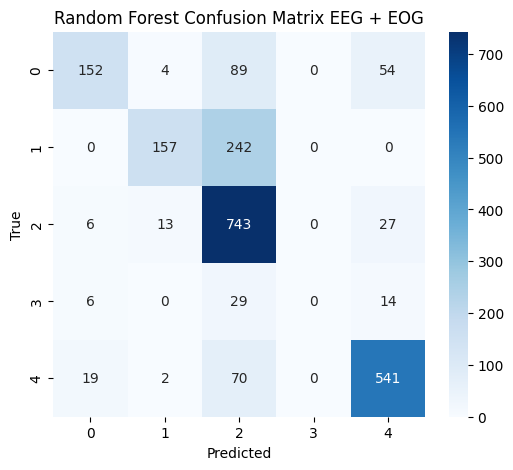

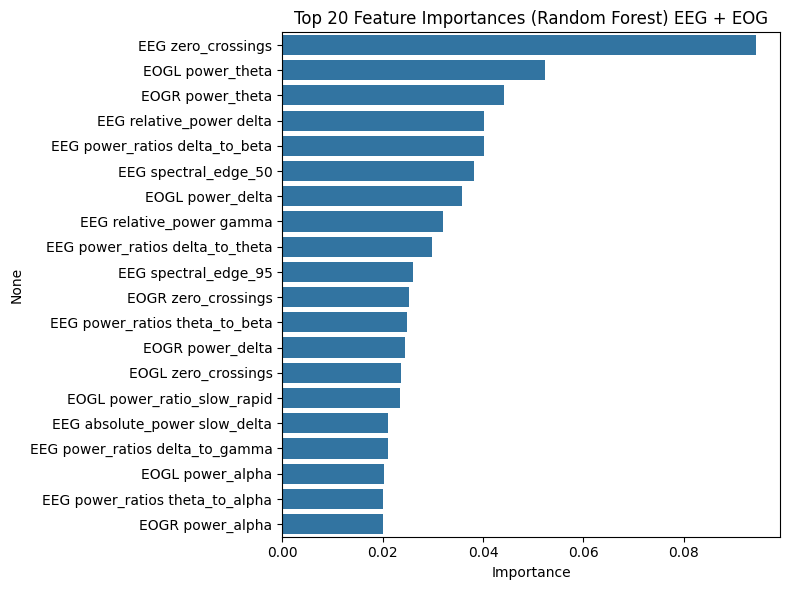

Dropping 31 features with |corr| > 0.95:
['EEG variance', 'EEG std', 'EEG hjorth_activity', 'EEG hjorth_mobility', 'EEG absolute_power alpha', 'EEG absolute_power beta', 'EEG absolute_power gamma', 'EEG relative_power beta', 'EOGL movement_density_mean', 'EOGL signal_std', 'EOGL power_beta', 'EOGL power_total', 'EOGR movement_density_mean', 'EOGR signal_std', 'EOGR power_beta', 'EOGR power_total', 'ECG variance', 'ECG std', 'ECG rms', 'ECG mad', 'ECG hjorth_activity', 'ECG C0_std', 'ECG C0_energy', 'ECG D1_std', 'ECG D1_energy', 'ECG D2_std', 'ECG D2_energy', 'ECG D3_std', 'ECG D3_energy', 'ECG D4_std', 'ECG D4_energy']

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.77      0.38      0.51       299
           1       0.90      0.28      0.42       399
           2       0.62      0.92      0.74       789
           3       0.00      0.00      0.00        49
           4       0.76      0.86      0.81       632

    accuracy   

c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


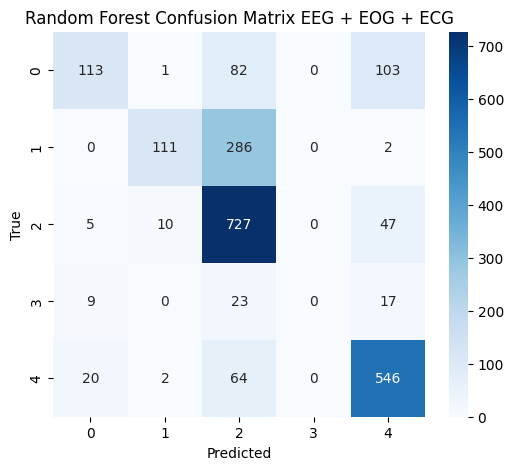

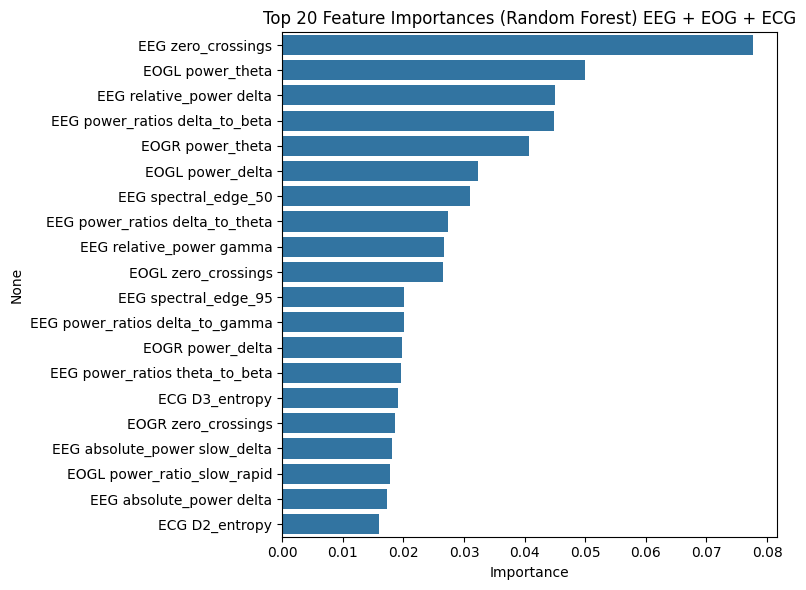

In [5]:
# --- 1) Prepare data ---
# `df` has columns: ['patient_id','epoch_id','label', ... feature columns ...]
id_cols = ['patient_id', 'epoch_id']
label_col = 'label'

label_list ={}
results_list = {}
accuracy_list ={}
for i, df in enumerate(df_list):
    # Separate out IDs and target
    ids    = df[id_cols]
    y      = df[label_col]
    X_full = df.drop(columns=id_cols + [label_col])

    # --- 2) Drop highly correlated features ---
    def drop_high_corr(X, threshold=0.95):
        corr = X.corr().abs()
        np.fill_diagonal(corr.values, 0)
        to_drop = [col for col in corr.columns if any(corr[col] > threshold)]
        print(f"Dropping {len(to_drop)} features with |corr| > {threshold}:")
        print(to_drop)
        return X.drop(columns=to_drop)

    X_uncorr = drop_high_corr(X_full, threshold=0.95)

    # For now we'll just proceed with X_uncorr:
    X_processed = pd.concat([ids.reset_index(drop=True), y.reset_index(drop=True), X_uncorr], axis=1)

    # Split based on patient_id
    train_patients = [1, 2, 3, 4, 5, 6, 7, 8]
    test_patients  = [9, 10]

    # Create train/test sets
    train_df = X_processed[X_processed['patient_id'].isin(train_patients)]
    test_df  = X_processed[X_processed['patient_id'].isin(test_patients)]

    # Extract features and labels
    X_train = train_df.drop(columns=id_cols + [label_col])
    y_train = train_df['label']
    X_test  = test_df.drop(columns=id_cols + [label_col])
    y_test  = test_df['label']

    # --- 5) Train Random Forest ---
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)

    # --- 6) Evaluate ---
    y_pred_rf = rf.predict(X_test)
    results_list[name_list[i]] = y_pred_rf
    label_list [name_list[i]] = y_test

    print("\n=== Classification Report ===")
    print(classification_report(y_test, y_pred_rf))
    print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
    accuracy_list[name_list[i]] = accuracy_score(y_test, y_pred_rf)

    cm = confusion_matrix(y_test, y_pred_rf)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Random Forest Confusion Matrix ' + name_list[i])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # --- 7) Feature importances ---
    importances = pd.Series(rf.feature_importances_, index=X_train.columns)
    importances = importances.sort_values(ascending=False).head(20)
    plt.figure(figsize=(8,6))
    sns.barplot(x=importances.values, y=importances.index, orient='h')
    plt.title('Top 20 Feature Importances (Random Forest) ' + name_list[i])
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


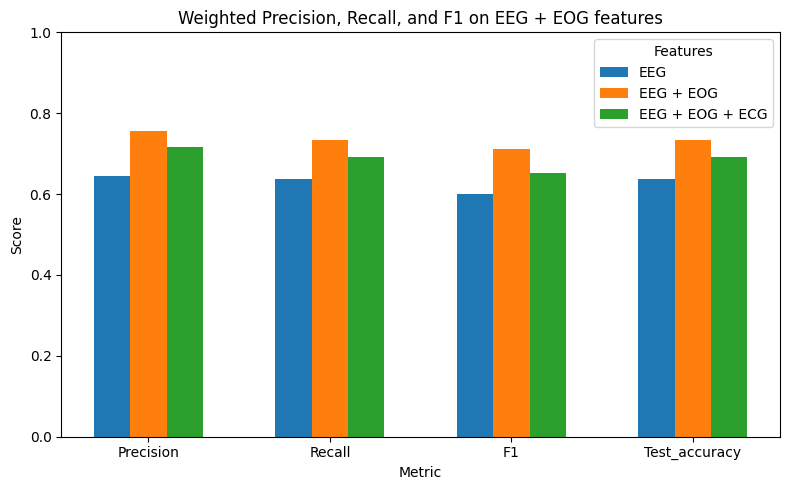

In [6]:
# Compare the evolution of performance when adding new signal features
# 1) Compute weighted metrics for each model
model_preds = results_list

metrics = ['precision', 'recall', 'f1', 'test_accuracy']
results = {}
for name, preds in model_preds.items():
    results[name] = [
        precision_score(label_list[name], preds, average='weighted'),
        recall_score(   label_list[name], preds, average='weighted'),
        f1_score(       label_list[name], preds, average='weighted'),
        accuracy_list[name]
    ]

# 2) Prepare for plotting
labels = [m.capitalize() for m in metrics]
x = np.arange(len(labels))
width = 0.2  # width of each bar

# 3) Create grouped bar chart
plt.figure(figsize=(8, 5))
for i, (df, scores) in enumerate(results.items()):
    plt.bar(x + (i - 1)*width, scores, width, label=df)

# 4) Labels and legend
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Weighted Precision, Recall, and F1 on EEG + EOG features')
plt.legend(title='Features')
plt.tight_layout()
plt.show()


# The importance of wavelet features
Here we demonstrate the crucial importance of EEG wavelet features training a performant classifier. 

In [38]:
# Load create the dataframes decribed above
EEG_col = [col for col in df_no_AR.columns if 'EEG' in col]
EOG_col = [col for col in df_no_AR.columns if 'EOG' in col]
ECG_col = [col for col in df_no_AR.columns if 'ECG' in col]

df1 = df_no_AR.drop(columns= ECG_col)
df2 = df1

# Drop the wavelet features
df1 = df_raw.drop(columns=['EEG absolute_power slow_delta', 'EEG absolute_power delta',
       'EEG absolute_power theta', 'EEG absolute_power alpha',
       'EEG absolute_power beta', 'EEG absolute_power gamma',
       'EEG relative_power slow_delta', 'EEG relative_power delta',
       'EEG relative_power theta', 'EEG relative_power alpha',
       'EEG relative_power beta', 'EEG relative_power gamma',
       'EEG power_ratios slow_delta_to_delta',
       'EEG power_ratios delta_to_theta', 'EEG power_ratios theta_to_alpha',
       'EEG power_ratios alpha_to_beta', 'EEG power_ratios delta_to_beta',
       'EEG power_ratios theta_to_beta',
       'EEG power_ratios slow_delta_to_gamma',
       'EEG power_ratios delta_to_gamma', 'EEG spindle_density'])



df_list = [df1,df2]
name_list = ['no_wavelets', 'wavelets']

Dropping 19 features with |corr| > 0.95:
['EEG variance', 'EEG std', 'EEG hjorth_activity', 'EOGL movement_density_mean', 'EOGL signal_std', 'EOGR movement_density_mean', 'EOGR signal_std', 'EOGR power_delta', 'EOGR power_total', 'ECG variance', 'ECG std', 'ECG rms', 'ECG hjorth_activity', 'ECG lf_power', 'ECG hf_power', 'ECG D1_std', 'ECG D1_energy', 'ECG D2_std', 'ECG D2_energy']

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.75      0.28      0.41       298
           1       0.94      0.20      0.32       399
           2       0.61      0.85      0.71       784
           3       0.00      0.00      0.00        47
           4       0.38      0.78      0.51       227

    accuracy                           0.57      1755
   macro avg       0.54      0.42      0.39      1755
weighted avg       0.66      0.57      0.53      1755

Accuracy: 0.5715


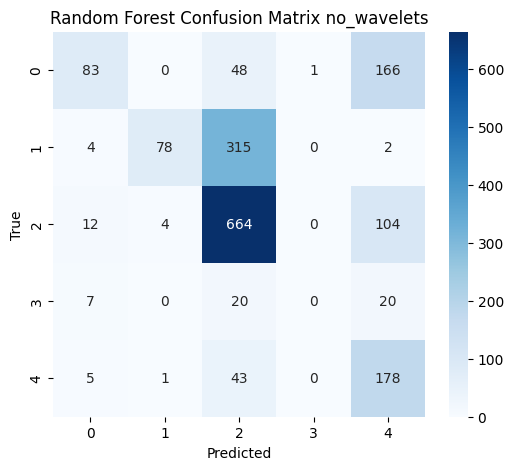

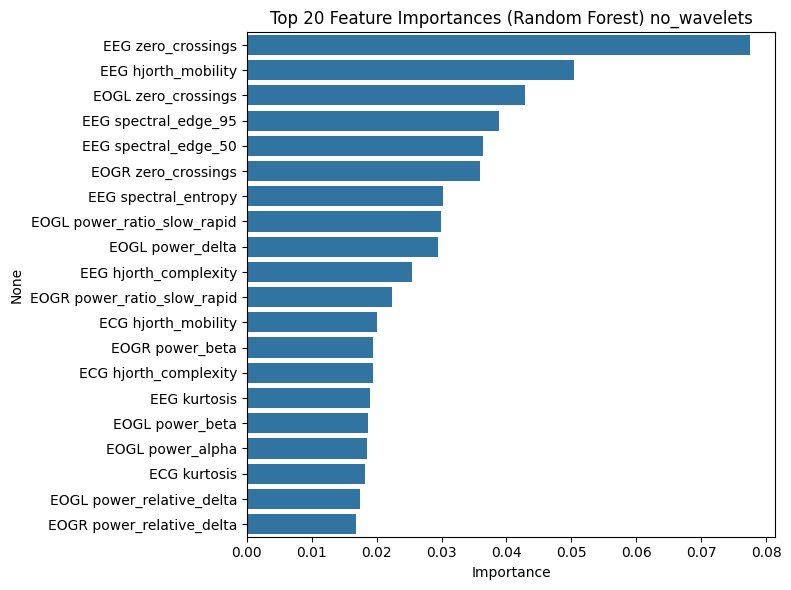

Dropping 16 features with |corr| > 0.95:
['EEG variance', 'EEG std', 'EEG hjorth_activity', 'EEG hjorth_mobility', 'EEG absolute_power alpha', 'EEG absolute_power beta', 'EEG absolute_power gamma', 'EEG relative_power beta', 'EOGL movement_density_mean', 'EOGL signal_std', 'EOGL power_beta', 'EOGL power_total', 'EOGR movement_density_mean', 'EOGR signal_std', 'EOGR power_beta', 'EOGR power_total']

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.83      0.51      0.63       299
           1       0.89      0.39      0.55       399
           2       0.63      0.94      0.76       789
           3       0.00      0.00      0.00        49
           4       0.85      0.86      0.85       632

    accuracy                           0.73      2168
   macro avg       0.64      0.54      0.56      2168
weighted avg       0.76      0.73      0.71      2168

Accuracy: 0.7348


c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


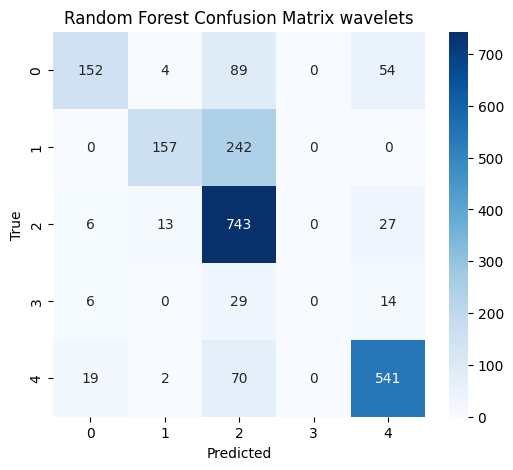

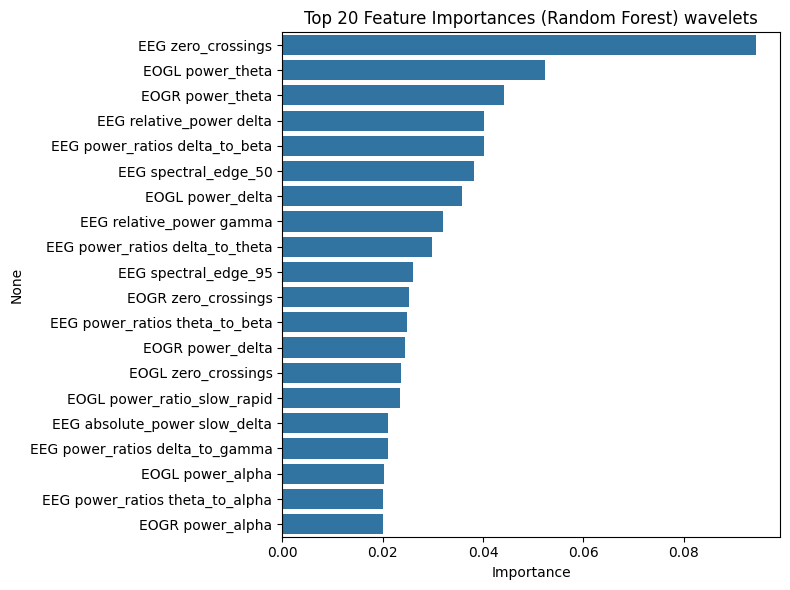

In [39]:
# --- 1) Prepare data ---
# `df` has columns: ['patient_id','epoch_id','label', ... feature columns ...]
id_cols = ['patient_id', 'epoch_id']
label_col = 'label'

label_list ={}
results_list = {}
accuracy_list = {}
for i, df in enumerate(df_list):
    # Separate out IDs and target
    ids    = df[id_cols]
    y      = df[label_col]
    X_full = df.drop(columns=id_cols + [label_col])

    # --- 2) Drop highly correlated features ---
    def drop_high_corr(X, threshold=0.95):
        corr = X.corr().abs()
        np.fill_diagonal(corr.values, 0)
        to_drop = [col for col in corr.columns if any(corr[col] > threshold)]
        print(f"Dropping {len(to_drop)} features with |corr| > {threshold}:")
        print(to_drop)
        return X.drop(columns=to_drop)

    X_uncorr = drop_high_corr(X_full, threshold=0.95)

    # For now we'll just proceed with X_uncorr:
    X_processed = pd.concat([ids.reset_index(drop=True), y.reset_index(drop=True), X_uncorr], axis=1)

    # Split based on patient_id
    train_patients = [1, 2, 3, 4, 5, 6, 7, 8]
    test_patients  = [9, 10]

    # Create train/test sets
    train_df = X_processed[X_processed['patient_id'].isin(train_patients)]
    test_df  = X_processed[X_processed['patient_id'].isin(test_patients)]

    # Extract features and labels
    X_train = train_df.drop(columns=id_cols + [label_col])
    y_train = train_df['label']
    X_test  = test_df.drop(columns=id_cols + [label_col])
    y_test  = test_df['label']

    # --- 5) Train Random Forest ---
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)

    # --- 6) Evaluate ---
    y_pred_rf = rf.predict(X_test)
    results_list[name_list[i]] = y_pred_rf
    label_list [name_list[i]] = y_test

    print("\n=== Classification Report ===")
    print(classification_report(y_test, y_pred_rf))
    print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
    accuracy_list[name_list[i]] = accuracy_score(y_test, y_pred_rf)

    cm = confusion_matrix(y_test, y_pred_rf)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Random Forest Confusion Matrix ' + name_list[i])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # --- 7) Feature importances ---
    importances = pd.Series(rf.feature_importances_, index=X_train.columns)
    importances = importances.sort_values(ascending=False).head(20)
    plt.figure(figsize=(8,6))
    sns.barplot(x=importances.values, y=importances.index, orient='h')
    plt.title('Top 20 Feature Importances (Random Forest) ' + name_list[i])
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


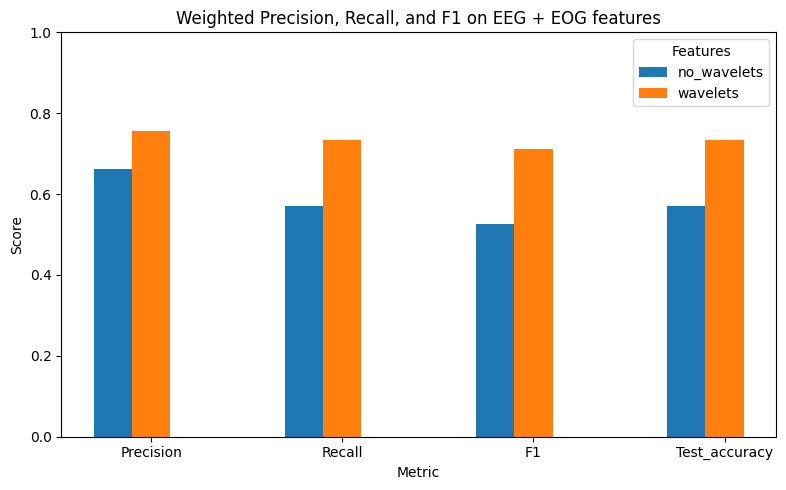

In [40]:
# Compare the evolution of performance when adding new signal features
# 1) Compute weighted metrics for each model
model_preds = results_list

metrics = ['precision', 'recall', 'f1', 'test_accuracy']
results = {}
for name, preds in model_preds.items():
    results[name] = [
        precision_score(label_list[name], preds, average='weighted'),
        recall_score(   label_list[name], preds, average='weighted'),
        f1_score(       label_list[name], preds, average='weighted'),
        accuracy_list[name]
    ]

# 2) Prepare for plotting
labels = [m.capitalize() for m in metrics]
x = np.arange(len(labels))
width = 0.2  # width of each bar

# 3) Create grouped bar chart
plt.figure(figsize=(8, 5))
for i, (df, scores) in enumerate(results.items()):
    plt.bar(x + (i - 1)*width, scores, width, label=df)

# 4) Labels and legend
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Weighted Precision, Recall, and F1 on EEG + EOG features')
plt.legend(title='Features')
plt.tight_layout()
plt.show()


# The impovements due to the ICA preprocessing

In [10]:
df_no_ICA = pd.read_csv('all_features_no_ICA.csv')

In [11]:
# Load create the dataframes decribed above
EEG_col = [col for col in df_raw.columns if 'EEG' in col]
EOG_col = [col for col in df_raw.columns if 'EOG' in col]
ECG_col = [col for col in df_raw.columns if 'ECG' in col]

df1 = df_raw.drop(columns=ECG_col)    # Contains EEG ICA cleaned signal & EOG signal features
df2 = df_no_ICA.drop(columns=ECG_col)    # Contains EEG not ICA cleaned signal & EOG signal features


df_list = [df1,df2]
name_list = ['ICA cleaned','Not ICA cleaned']

Dropping 13 features with |corr| > 0.95:
['EEG variance', 'EEG std', 'EEG hjorth_activity', 'EEG hjorth_mobility', 'EEG absolute_power delta', 'EEG relative_power beta', 'EEG power_ratios delta_to_gamma', 'EOGL movement_density_mean', 'EOGL signal_std', 'EOGR movement_density_mean', 'EOGR signal_std', 'EOGR power_delta', 'EOGR power_total']

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.89      0.36      0.52       298
           1       0.87      0.48      0.61       399
           2       0.65      0.93      0.77       784
           3       0.00      0.00      0.00        47
           4       0.58      0.74      0.65       227

    accuracy                           0.68      1755
   macro avg       0.60      0.50      0.51      1755
weighted avg       0.72      0.68      0.65      1755

Accuracy: 0.6826


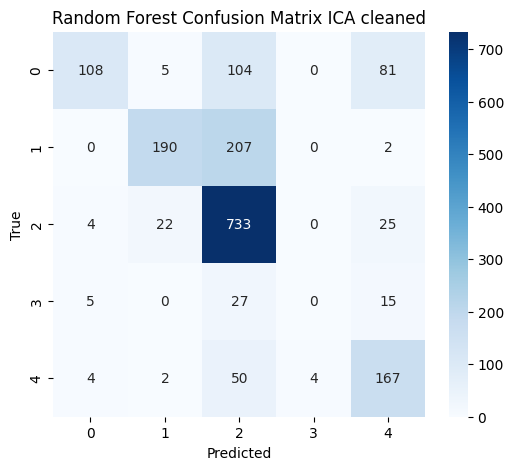

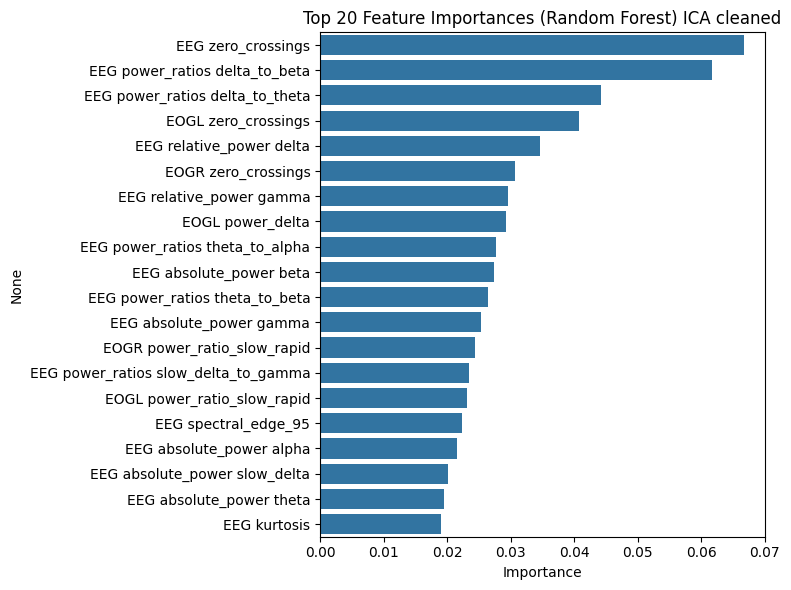

Dropping 16 features with |corr| > 0.95:
['EEG variance', 'EEG std', 'EEG hjorth_activity', 'EEG hjorth_mobility', 'EEG spectral_edge_95', 'EEG absolute_power slow_delta', 'EEG absolute_power delta', 'EEG relative_power beta', 'EEG power_ratios slow_delta_to_gamma', 'EEG power_ratios delta_to_gamma', 'EOGL movement_density_mean', 'EOGL signal_std', 'EOGR movement_density_mean', 'EOGR signal_std', 'EOGR power_delta', 'EOGR power_total']

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.82      0.33      0.47       298
           1       0.86      0.44      0.58       399
           2       0.64      0.93      0.75       784
           3       0.00      0.00      0.00        47
           4       0.53      0.67      0.59       227

    accuracy                           0.66      1755
   macro avg       0.57      0.47      0.48      1755
weighted avg       0.69      0.66      0.63      1755

Accuracy: 0.6558


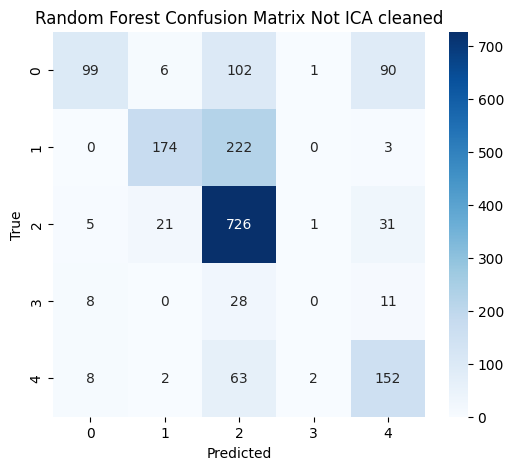

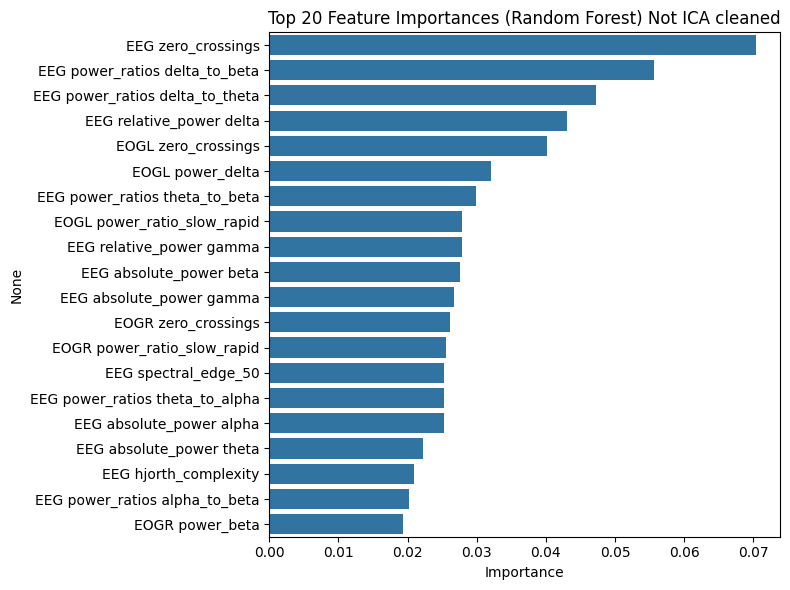

In [12]:
# --- 1) Prepare data ---
# `df` has columns: ['patient_id','epoch_id','label', ... feature columns ...]
id_cols = ['patient_id', 'epoch_id']
label_col = 'label'

label_list ={}
results_list = {}
accuracy_list ={}
for i, df in enumerate(df_list):
    # Separate out IDs and target
    ids    = df[id_cols]
    y      = df[label_col]
    X_full = df.drop(columns=id_cols + [label_col])

    # --- 2) Drop highly correlated features ---
    def drop_high_corr(X, threshold=0.95):
        corr = X.corr().abs()
        np.fill_diagonal(corr.values, 0)
        to_drop = [col for col in corr.columns if any(corr[col] > threshold)]
        print(f"Dropping {len(to_drop)} features with |corr| > {threshold}:")
        print(to_drop)
        return X.drop(columns=to_drop)

    X_uncorr = drop_high_corr(X_full, threshold=0.95)

    # For now we'll just proceed with X_uncorr:
    X_processed = pd.concat([ids.reset_index(drop=True), y.reset_index(drop=True), X_uncorr], axis=1)

    # Split based on patient_id
    train_patients = [1, 2, 3, 4, 5, 6, 7, 8]
    test_patients  = [9, 10]

    # Create train/test sets
    train_df = X_processed[X_processed['patient_id'].isin(train_patients)]
    test_df  = X_processed[X_processed['patient_id'].isin(test_patients)]

    # Extract features and labels
    X_train = train_df.drop(columns=id_cols + [label_col])
    y_train = train_df['label']
    X_test  = test_df.drop(columns=id_cols + [label_col])
    y_test  = test_df['label']

    # --- 5) Train Random Forest ---
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)

    # --- 6) Evaluate ---
    y_pred_rf = rf.predict(X_test)
    results_list[name_list[i]] = y_pred_rf
    label_list [name_list[i]] = y_test

    print("\n=== Classification Report ===")
    print(classification_report(y_test, y_pred_rf))
    print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
    accuracy_list[name_list[i]] = accuracy_score(y_test, y_pred_rf)

    cm = confusion_matrix(y_test, y_pred_rf)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Random Forest Confusion Matrix ' + name_list[i])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # --- 7) Feature importances ---
    importances = pd.Series(rf.feature_importances_, index=X_train.columns)
    importances = importances.sort_values(ascending=False).head(20)
    plt.figure(figsize=(8,6))
    sns.barplot(x=importances.values, y=importances.index, orient='h')
    plt.title('Top 20 Feature Importances (Random Forest) ' + name_list[i])
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

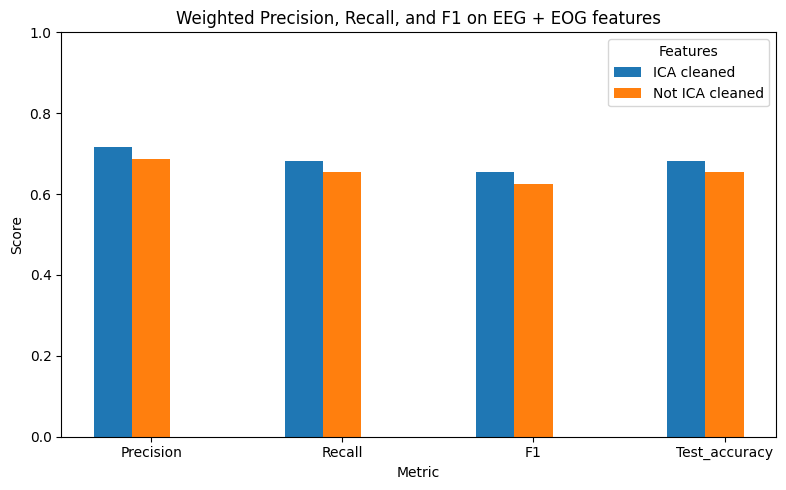

In [13]:
# Compare the evolution of performance when adding new signal features
# 1) Compute weighted metrics for each model
model_preds = results_list

metrics = ['precision', 'recall', 'f1', 'test_accuracy']
results = {}
for name, preds in model_preds.items():
    results[name] = [
        precision_score(label_list[name], preds, average='weighted'),
        recall_score(   label_list[name], preds, average='weighted'),
        f1_score(       label_list[name], preds, average='weighted'),
        accuracy_list[name]
    ]

# 2) Prepare for plotting
labels = [m.capitalize() for m in metrics]
x = np.arange(len(labels))
width = 0.2  # width of each bar

# 3) Create grouped bar chart
plt.figure(figsize=(8, 5))
for i, (df, scores) in enumerate(results.items()):
    plt.bar(x + (i - 1)*width, scores, width, label=df)

# 4) Labels and legend
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Weighted Precision, Recall, and F1 on EEG + EOG features')
plt.legend(title='Features')
plt.tight_layout()
plt.show()


# Artifact removal utility

In [14]:
df_no_AR = pd.read_csv('all_features_no_artifact_removal.csv')

In [15]:
# Load create the dataframes decribed above
EEG_col = [col for col in df_raw.columns if 'EEG' in col]
EOG_col = [col for col in df_raw.columns if 'EOG' in col]
ECG_col = [col for col in df_raw.columns if 'ECG' in col]

df1 = df_raw.drop(columns=ECG_col)    # Contains EEG ICA cleaned signal & EOG signal features
df2 = df_no_AR.drop(columns=ECG_col)    # Contains EEG not ICA cleaned signal & EOG signal features


df_list = [df1,df2]
name_list = ['Artifact Removal','No Artifact Removal']

Dropping 13 features with |corr| > 0.95:
['EEG variance', 'EEG std', 'EEG hjorth_activity', 'EEG hjorth_mobility', 'EEG absolute_power delta', 'EEG relative_power beta', 'EEG power_ratios delta_to_gamma', 'EOGL movement_density_mean', 'EOGL signal_std', 'EOGR movement_density_mean', 'EOGR signal_std', 'EOGR power_delta', 'EOGR power_total']

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.89      0.36      0.52       298
           1       0.87      0.48      0.61       399
           2       0.65      0.93      0.77       784
           3       0.00      0.00      0.00        47
           4       0.58      0.74      0.65       227

    accuracy                           0.68      1755
   macro avg       0.60      0.50      0.51      1755
weighted avg       0.72      0.68      0.65      1755

Accuracy: 0.6826


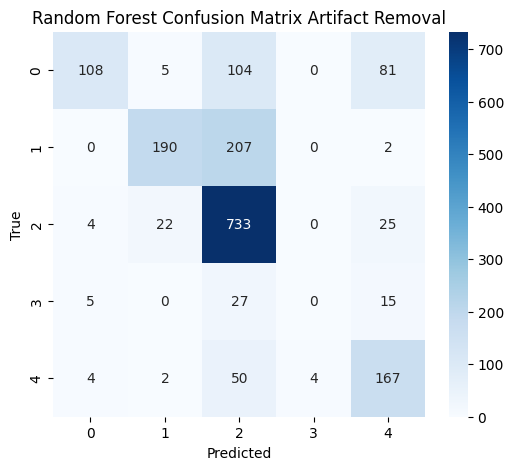

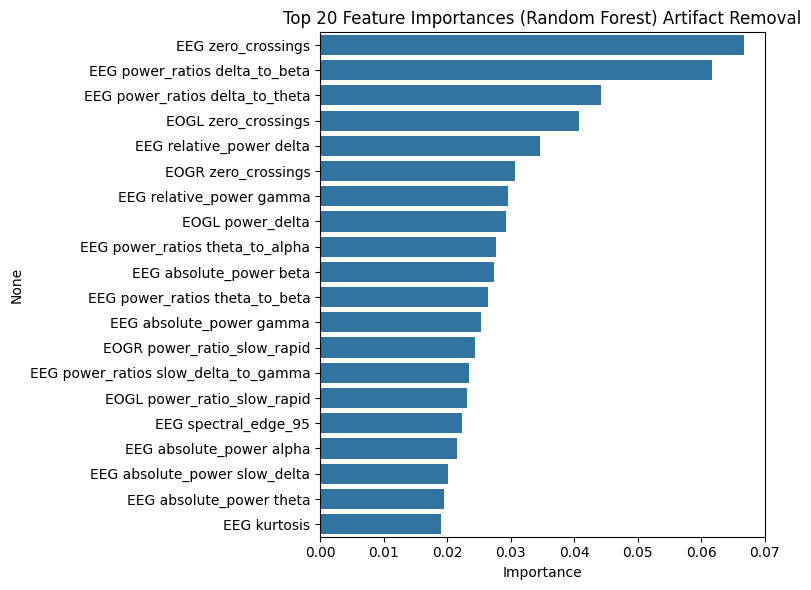

Dropping 16 features with |corr| > 0.95:
['EEG variance', 'EEG std', 'EEG hjorth_activity', 'EEG hjorth_mobility', 'EEG absolute_power alpha', 'EEG absolute_power beta', 'EEG absolute_power gamma', 'EEG relative_power beta', 'EOGL movement_density_mean', 'EOGL signal_std', 'EOGL power_beta', 'EOGL power_total', 'EOGR movement_density_mean', 'EOGR signal_std', 'EOGR power_beta', 'EOGR power_total']

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.83      0.51      0.63       299
           1       0.89      0.39      0.55       399
           2       0.63      0.94      0.76       789
           3       0.00      0.00      0.00        49
           4       0.85      0.86      0.85       632

    accuracy                           0.73      2168
   macro avg       0.64      0.54      0.56      2168
weighted avg       0.76      0.73      0.71      2168

Accuracy: 0.7348


c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


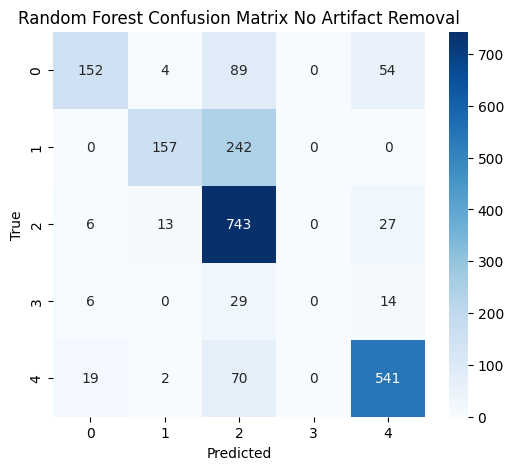

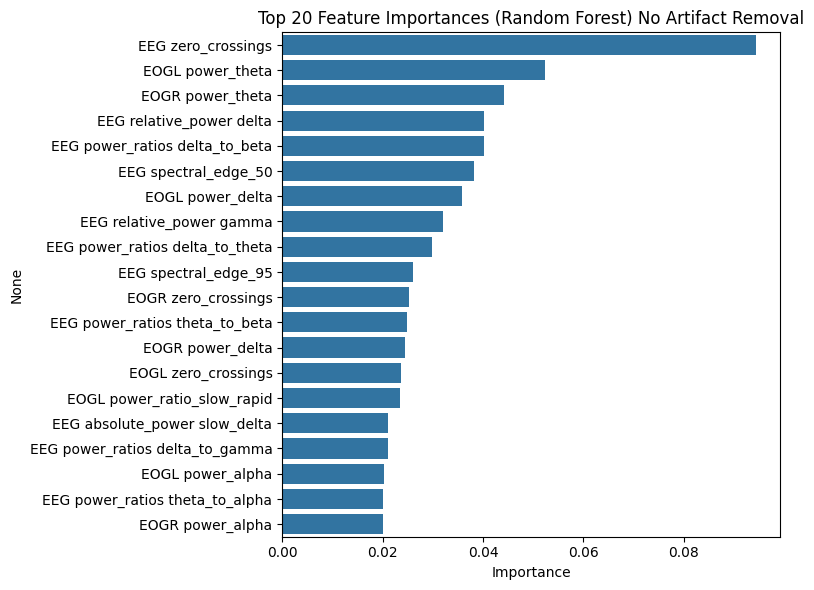

In [16]:
# --- 1) Prepare data ---
# `df` has columns: ['patient_id','epoch_id','label', ... feature columns ...]
id_cols = ['patient_id', 'epoch_id']
label_col = 'label'

label_list ={}
results_list = {}
accuracy_list = {}
for i, df in enumerate(df_list):
    # Separate out IDs and target
    ids    = df[id_cols]
    y      = df[label_col]
    X_full = df.drop(columns=id_cols + [label_col])

    # --- 2) Drop highly correlated features ---
    def drop_high_corr(X, threshold=0.95):
        corr = X.corr().abs()
        np.fill_diagonal(corr.values, 0)
        to_drop = [col for col in corr.columns if any(corr[col] > threshold)]
        print(f"Dropping {len(to_drop)} features with |corr| > {threshold}:")
        print(to_drop)
        return X.drop(columns=to_drop)

    X_uncorr = drop_high_corr(X_full, threshold=0.95)

    # For now we'll just proceed with X_uncorr:
    X_processed = pd.concat([ids.reset_index(drop=True), y.reset_index(drop=True), X_uncorr], axis=1)

    # Split based on patient_id
    train_patients = [1, 2, 3, 4, 5, 6, 7, 8]
    test_patients  = [9, 10]

    # Create train/test sets
    train_df = X_processed[X_processed['patient_id'].isin(train_patients)]
    test_df  = X_processed[X_processed['patient_id'].isin(test_patients)]

    # Extract features and labels
    X_train = train_df.drop(columns=id_cols + [label_col])
    y_train = train_df['label']
    X_test  = test_df.drop(columns=id_cols + [label_col])
    y_test  = test_df['label']

    # --- 5) Train Random Forest ---
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)

    # --- 6) Evaluate ---
    y_pred_rf = rf.predict(X_test)
    results_list[name_list[i]] = y_pred_rf
    label_list [name_list[i]] = y_test

    print("\n=== Classification Report ===")
    print(classification_report(y_test, y_pred_rf))
    print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
    accuracy_list[name_list[i]] = accuracy_score(y_test, y_pred_rf)

    cm = confusion_matrix(y_test, y_pred_rf)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Random Forest Confusion Matrix ' + name_list[i])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # --- 7) Feature importances ---
    importances = pd.Series(rf.feature_importances_, index=X_train.columns)
    importances = importances.sort_values(ascending=False).head(20)
    plt.figure(figsize=(8,6))
    sns.barplot(x=importances.values, y=importances.index, orient='h')
    plt.title('Top 20 Feature Importances (Random Forest) ' + name_list[i])
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


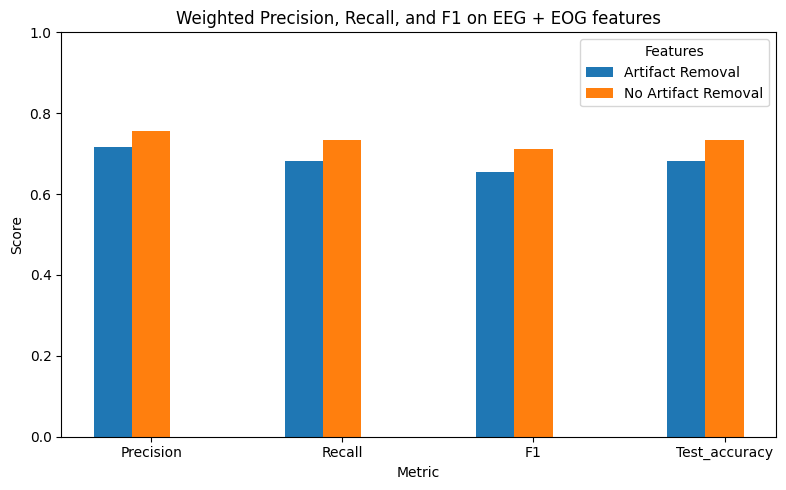

In [17]:
# Compare the evolution of performance when adding new signal features
# 1) Compute weighted metrics for each model
model_preds = results_list

metrics = ['precision', 'recall', 'f1', 'test_accuracy']
results = {}
for name, preds in model_preds.items():
    results[name] = [
        precision_score(label_list[name], preds, average='weighted'),
        recall_score(   label_list[name], preds, average='weighted'),
        f1_score(       label_list[name], preds, average='weighted'),
        accuracy_list[name]
    ]

# 2) Prepare for plotting
labels = [m.capitalize() for m in metrics]
x = np.arange(len(labels))
width = 0.2  # width of each bar

# 3) Create grouped bar chart
plt.figure(figsize=(8, 5))
for i, (df, scores) in enumerate(results.items()):
    plt.bar(x + (i - 1)*width, scores, width, label=df)

# 4) Labels and legend
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Weighted Precision, Recall, and F1 on EEG + EOG features')
plt.legend(title='Features')
plt.tight_layout()
plt.show()


# Handling class imbalance

In [10]:
from sklearn.utils import resample

In [11]:
# Load create the dataframes decribed above
EEG_col = [col for col in df_no_AR.columns if 'EEG' in col]
EOG_col = [col for col in df_no_AR.columns if 'EOG' in col]
ECG_col = [col for col in df_no_AR.columns if 'ECG' in col]

df = df_no_AR.drop(columns=ECG_col)    # Contains EEG ICA cleaned signal & EOG signal features

name_list = ['raw','oversampled']

Dropping 16 features with |corr| > 0.95:
['EEG variance', 'EEG std', 'EEG hjorth_activity', 'EEG hjorth_mobility', 'EEG absolute_power alpha', 'EEG absolute_power beta', 'EEG absolute_power gamma', 'EEG relative_power beta', 'EOGL movement_density_mean', 'EOGL signal_std', 'EOGL power_beta', 'EOGL power_total', 'EOGR movement_density_mean', 'EOGR signal_std', 'EOGR power_beta', 'EOGR power_total']

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.83      0.51      0.63       299
           1       0.89      0.39      0.55       399
           2       0.63      0.94      0.76       789
           3       0.00      0.00      0.00        49
           4       0.85      0.86      0.85       632

    accuracy                           0.73      2168
   macro avg       0.64      0.54      0.56      2168
weighted avg       0.76      0.73      0.71      2168

Accuracy: 0.7348


c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


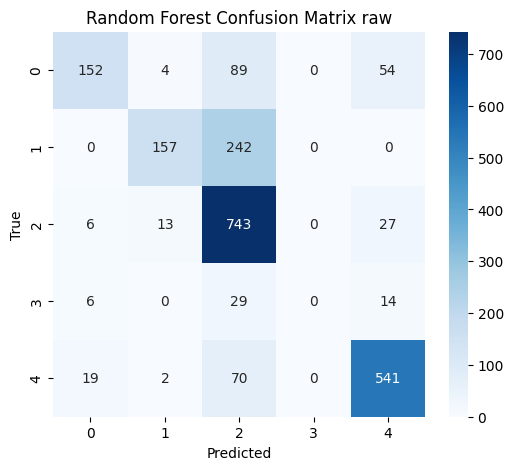

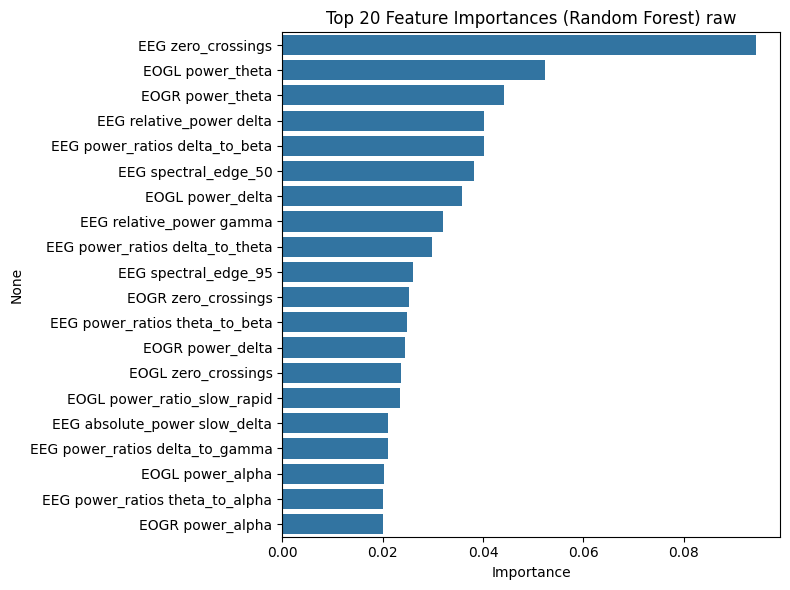

Dropping 16 features with |corr| > 0.95:
['EEG variance', 'EEG std', 'EEG hjorth_activity', 'EEG hjorth_mobility', 'EEG absolute_power alpha', 'EEG absolute_power beta', 'EEG absolute_power gamma', 'EEG relative_power beta', 'EOGL movement_density_mean', 'EOGL signal_std', 'EOGL power_beta', 'EOGL power_total', 'EOGR movement_density_mean', 'EOGR signal_std', 'EOGR power_beta', 'EOGR power_total']
Balanced class distribution:
label
2    3019
0    3019
1    3019
4    3019
3    3019
Name: count, dtype: int64

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.78      0.61      0.68       299
           1       0.89      0.41      0.57       399
           2       0.65      0.94      0.77       789
           3       0.16      0.12      0.14        49
           4       0.88      0.80      0.84       632

    accuracy                           0.74      2168
   macro avg       0.67      0.58      0.60      2168
weighted avg       0.77

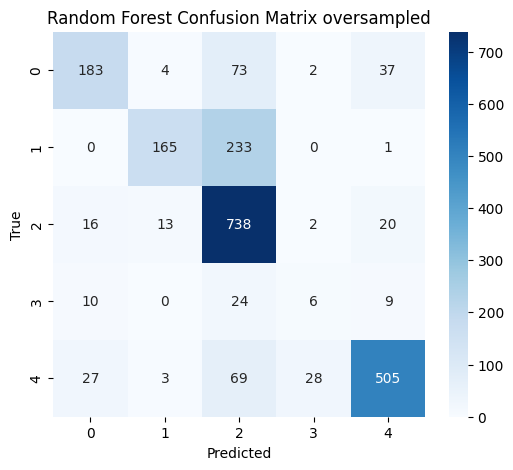

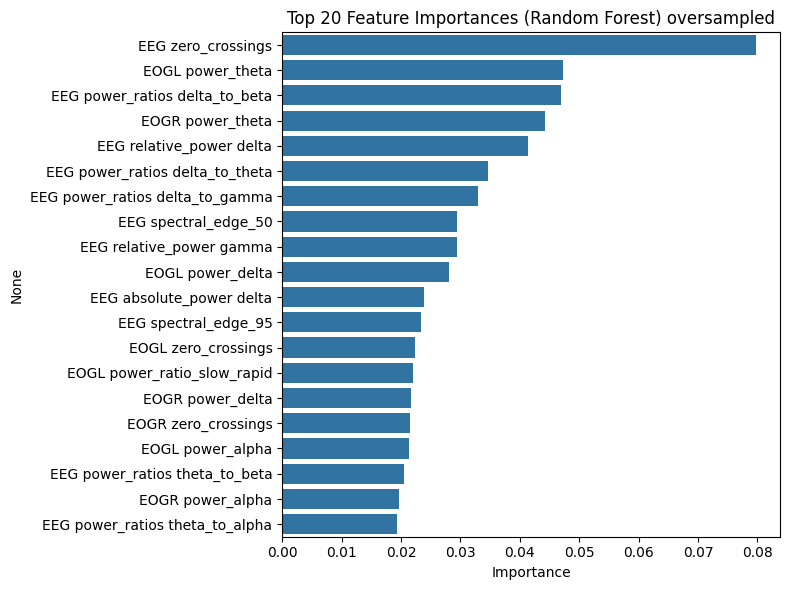

In [12]:
# --- 1) Prepare data ---
# `df` has columns: ['patient_id','epoch_id','label', ... feature columns ...]
id_cols = ['patient_id', 'epoch_id']
label_col = 'label'

label_list ={}
results_list = {}
accuracy_list = {}

for i in range(2):
    # Separate out IDs and target
    ids    = df[id_cols]
    y      = df[label_col]
    X_full = df.drop(columns=id_cols + [label_col])

    # --- 2) Drop highly correlated features ---
    def drop_high_corr(X, threshold=0.95):
        corr = X.corr().abs()
        np.fill_diagonal(corr.values, 0)
        to_drop = [col for col in corr.columns if any(corr[col] > threshold)]
        print(f"Dropping {len(to_drop)} features with |corr| > {threshold}:")
        print(to_drop)
        return X.drop(columns=to_drop)

    X_uncorr = drop_high_corr(X_full, threshold=0.95)

    # For now we'll just proceed with X_uncorr:
    X_processed = pd.concat([ids.reset_index(drop=True), y.reset_index(drop=True), X_uncorr], axis=1)

    # Split based on patient_id
    train_patients = [1, 2, 3, 4, 5, 6, 7, 8]
    test_patients  = [9, 10]

    # Create train/test sets
    train_df = X_processed[X_processed['patient_id'].isin(train_patients)]
    test_df  = X_processed[X_processed['patient_id'].isin(test_patients)]

    if i == 1:
        # Separate majority and minority classes
        majority_class = train_df['label'].value_counts().idxmax()
        max_count = train_df['label'].value_counts().max()

        # Create a list to store upsampled DataFrames
        df_upsampled = []

        # Loop over each class
        for label in train_df['label'].unique():
            class_df = train_df[train_df['label'] == label]
            if len(class_df) < max_count:
                class_upsampled = resample(class_df,
                                        replace=True,               # sample with replacement
                                        n_samples=max_count,        # match majority class
                                        random_state=42)
                df_upsampled.append(class_upsampled)
            else:
                df_upsampled.append(class_df)  # keep majority class as is

        # Combine all classes back together
        train_df = pd.concat(df_upsampled).sample(frac=1, random_state=42).reset_index(drop=True)

        # Show class distribution
        print("Balanced class distribution:")
        print(train_df['label'].value_counts())

    # Extract features and labels
    X_train = train_df.drop(columns=id_cols + [label_col])
    y_train = train_df['label']
    X_test  = test_df.drop(columns=id_cols + [label_col])
    y_test  = test_df['label']

    # --- 5) Train Random Forest ---
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)

    # --- 6) Evaluate ---
    y_pred_rf = rf.predict(X_test)
    results_list[name_list[i]] = y_pred_rf
    label_list [name_list[i]] = y_test

    print("\n=== Classification Report ===")
    print(classification_report(y_test, y_pred_rf))
    print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
    accuracy_list[name_list[i]] = accuracy_score(y_test, y_pred_rf)

    cm = confusion_matrix(y_test, y_pred_rf)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Random Forest Confusion Matrix ' + name_list[i])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # --- 7) Feature importances ---
    importances = pd.Series(rf.feature_importances_, index=X_train.columns)
    importances = importances.sort_values(ascending=False).head(20)
    plt.figure(figsize=(8,6))
    sns.barplot(x=importances.values, y=importances.index, orient='h')
    plt.title('Top 20 Feature Importances (Random Forest) ' + name_list[i])
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


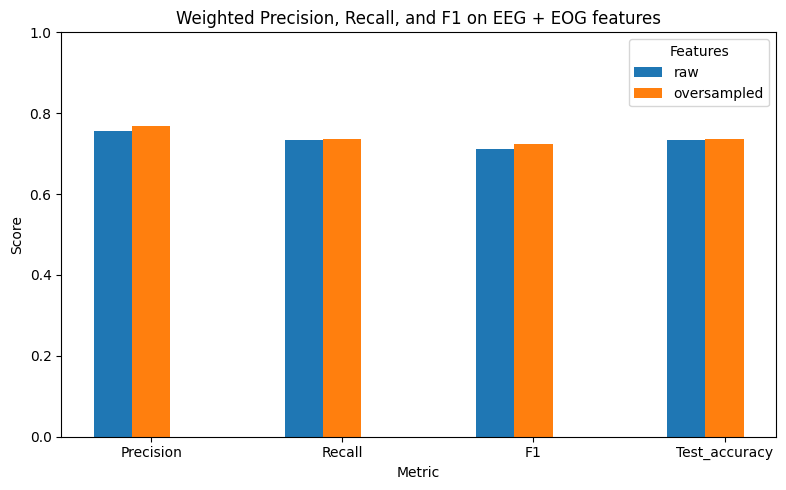

In [21]:
# Compare the evolution of performance when adding new signal features
# 1) Compute weighted metrics for each model
model_preds = results_list

metrics = ['precision', 'recall', 'f1', 'test_accuracy']
results = {}
for name, preds in model_preds.items():
    results[name] = [
        precision_score(label_list[name], preds, average='weighted'),
        recall_score(   label_list[name], preds, average='weighted'),
        f1_score(       label_list[name], preds, average='weighted'),
        accuracy_list[name]
    ]

# 2) Prepare for plotting
labels = [m.capitalize() for m in metrics]
x = np.arange(len(labels))
width = 0.2  # width of each bar

# 3) Create grouped bar chart
plt.figure(figsize=(8, 5))
for i, (df, scores) in enumerate(results.items()):
    plt.bar(x + (i - 1)*width, scores, width, label=df)

# 4) Labels and legend
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Weighted Precision, Recall, and F1 on EEG + EOG features')
plt.legend(title='Features')
plt.tight_layout()
plt.show()

c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


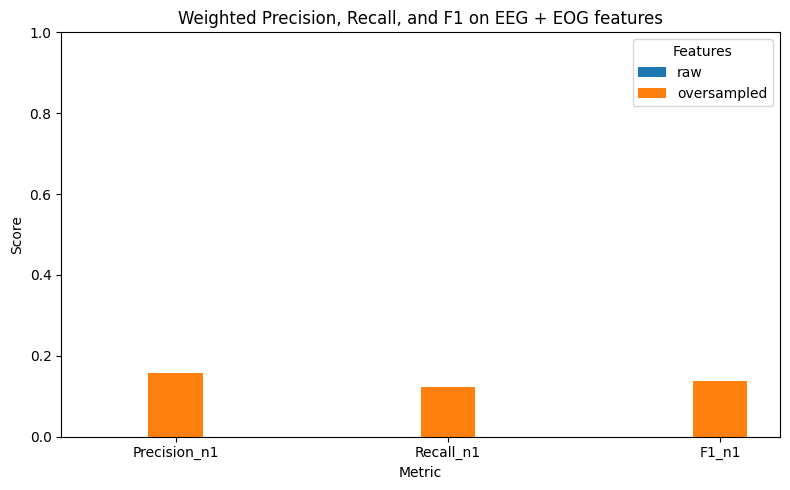

In [ ]:
# Compare the evolution of performance when adding new signal features
# 1) Compute weighted metrics for each model
model_preds = results_list

metrics = ['precision_N1', 'recall_N1', 'f1_N1']
results = {}

for name, preds in model_preds.items():
    true_labels = label_list[name]
    unique_labels = sorted(np.unique(true_labels))

    if 3 in unique_labels:
        class_idx = unique_labels.index(3)

        precision = precision_score(true_labels, preds, average=None)[class_idx]
        recall    = recall_score(true_labels, preds, average=None)[class_idx]
        f1        = f1_score(true_labels, preds, average=None)[class_idx]
    else:
        precision = recall = f1 = float('nan')  # class 3 not present

    results[name] = [precision, recall, f1]


# 2) Prepare for plotting
labels = [m.capitalize() for m in metrics]
x = np.arange(len(labels))
width = 0.2  # width of each bar

# 3) Create grouped bar chart
plt.figure(figsize=(8, 5))
for i, (df, scores) in enumerate(results.items()):
    plt.bar(x + (i - 1)*width, scores, width, label=df)

# 4) Labels and legend
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Weighted Precision, Recall, and F1 on EEG + EOG features')
plt.legend(title='Features')
plt.tight_layout()
plt.show()

# Effect of PCA

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

In [24]:
df = df_no_AR

# 1. Separate identifier and label columns
id_cols = ['patient_id', 'epoch_id']
label_col = 'label'

# Keep non-feature columns aside
ids = df[id_cols]
labels = df[label_col]
features = df.drop(columns=id_cols + [label_col])

# 2. Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
features_df = pd.DataFrame(features_scaled, columns=features.columns)

# 3. Plot correlation heatmap before PCA
corr_matrix = features_df.corr()

# 4. Identify highly correlated feature pairs (above 0.95)
threshold = 0.95
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            f1 = corr_matrix.columns[i]
            f2 = corr_matrix.columns[j]
            corr_val = corr_matrix.iloc[i, j]
            high_corr_pairs.append((f1, f2, corr_val))

# Print highly correlated feature pairs
print("\nHighly correlated feature pairs (|corr| > 0.95):")
for f1, f2, val in high_corr_pairs:
    print(f"{f1} & {f2} => correlation = {val:.3f}")

# Features to remove based on high correlation
features_to_remove = set([f for pair in high_corr_pairs for f in pair[:2]])
features_remaining = [f for f in features.columns if f not in features_to_remove]

# 5. Apply PCA (retain 95% of variance)
pca = PCA(n_components=0.95)
features_pca = pca.fit_transform(features_scaled)

# 5a. Explained variance and why these components were selected
explained_ratios = pca.explained_variance_ratio_
cumulative_ratios = explained_ratios.cumsum()
selected_n = pca.n_components_

print("\nComponents are selected because the cumulative explained variance reaches the 95% threshold at the last listed PC.")

# 7. Combine PCA result into final DataFrame
df_pca = pd.DataFrame(features_pca, columns=[f'PC{i+1}' for i in range(features_pca.shape[1])])
df_final_pca = pd.concat([ids.reset_index(drop=True), labels.reset_index(drop=True), df_pca], axis=1)


Highly correlated feature pairs (|corr| > 0.95):
EEG std & EEG variance => correlation = 0.963
EEG hjorth_activity & EEG variance => correlation = 1.000
EEG hjorth_activity & EEG std => correlation = 0.963
EEG absolute_power beta & EEG variance => correlation = 0.952
EEG absolute_power beta & EEG hjorth_activity => correlation = 0.952
EEG absolute_power beta & EEG absolute_power alpha => correlation = 0.951
EEG absolute_power gamma & EEG absolute_power alpha => correlation = 0.967
EEG relative_power beta & EEG hjorth_mobility => correlation = 0.950
EOGL signal_std & EOGL movement_density_mean => correlation = 0.999
EOGL power_total & EOGL movement_density_mean => correlation = 0.978
EOGL power_total & EOGL signal_std => correlation = 0.975
EOGL power_total & EOGL power_beta => correlation = 0.959
EOGR movement_density_mean & EOGL movement_density_mean => correlation = 0.993
EOGR movement_density_mean & EOGL signal_std => correlation = 0.992
EOGR movement_density_mean & EOGL power_tota

In [25]:
df1 = df_no_AR
df2 = df_final_pca

df_list = [df1,df2,df1,df2]
name_list = ['KNN no PCA','KNN PCA', 'RF no PCA', 'RF PCA']

Dropping 31 features with |corr| > 0.95:
['EEG variance', 'EEG std', 'EEG hjorth_activity', 'EEG hjorth_mobility', 'EEG absolute_power alpha', 'EEG absolute_power beta', 'EEG absolute_power gamma', 'EEG relative_power beta', 'EOGL movement_density_mean', 'EOGL signal_std', 'EOGL power_beta', 'EOGL power_total', 'EOGR movement_density_mean', 'EOGR signal_std', 'EOGR power_beta', 'EOGR power_total', 'ECG variance', 'ECG std', 'ECG rms', 'ECG mad', 'ECG hjorth_activity', 'ECG C0_std', 'ECG C0_energy', 'ECG D1_std', 'ECG D1_energy', 'ECG D2_std', 'ECG D2_energy', 'ECG D3_std', 'ECG D3_energy', 'ECG D4_std', 'ECG D4_energy']

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.19      0.09      0.13       299
           1       0.67      0.61      0.64       399
           2       0.46      0.62      0.53       789
           3       0.00      0.00      0.00        49
           4       0.46      0.41      0.43       632

    accuracy   

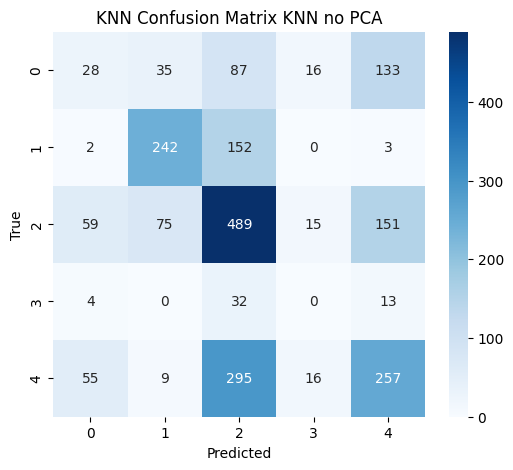

Dropping 0 features with |corr| > 0.95:
[]

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.56      0.41      0.48       299
           1       0.69      0.50      0.58       399
           2       0.59      0.83      0.68       789
           3       0.04      0.02      0.03        49
           4       0.81      0.66      0.73       632

    accuracy                           0.64      2168
   macro avg       0.54      0.48      0.50      2168
weighted avg       0.65      0.64      0.63      2168

Accuracy: 0.6430


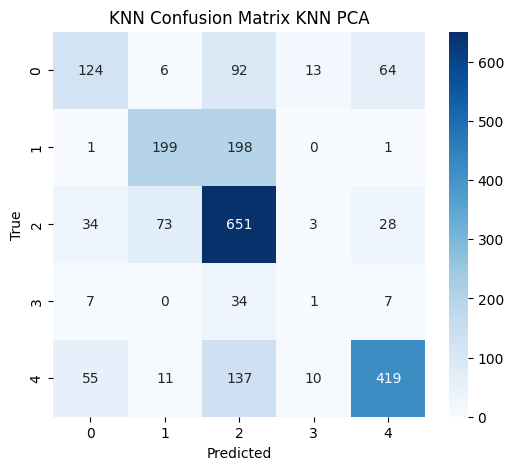

Dropping 31 features with |corr| > 0.95:
['EEG variance', 'EEG std', 'EEG hjorth_activity', 'EEG hjorth_mobility', 'EEG absolute_power alpha', 'EEG absolute_power beta', 'EEG absolute_power gamma', 'EEG relative_power beta', 'EOGL movement_density_mean', 'EOGL signal_std', 'EOGL power_beta', 'EOGL power_total', 'EOGR movement_density_mean', 'EOGR signal_std', 'EOGR power_beta', 'EOGR power_total', 'ECG variance', 'ECG std', 'ECG rms', 'ECG mad', 'ECG hjorth_activity', 'ECG C0_std', 'ECG C0_energy', 'ECG D1_std', 'ECG D1_energy', 'ECG D2_std', 'ECG D2_energy', 'ECG D3_std', 'ECG D3_energy', 'ECG D4_std', 'ECG D4_energy']

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.77      0.38      0.51       299
           1       0.90      0.28      0.42       399
           2       0.62      0.92      0.74       789
           3       0.00      0.00      0.00        49
           4       0.76      0.86      0.81       632

    accuracy   

c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


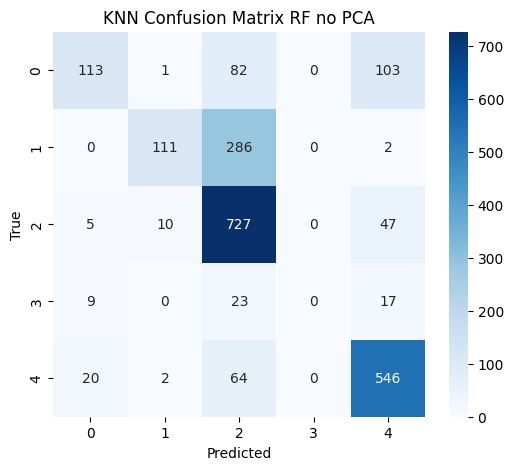

Dropping 0 features with |corr| > 0.95:
[]

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.71      0.18      0.29       299
           1       0.83      0.42      0.56       399
           2       0.58      0.83      0.68       789
           3       0.00      0.00      0.00        49
           4       0.65      0.79      0.71       632

    accuracy                           0.63      2168
   macro avg       0.55      0.44      0.45      2168
weighted avg       0.65      0.63      0.60      2168

Accuracy: 0.6324


c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


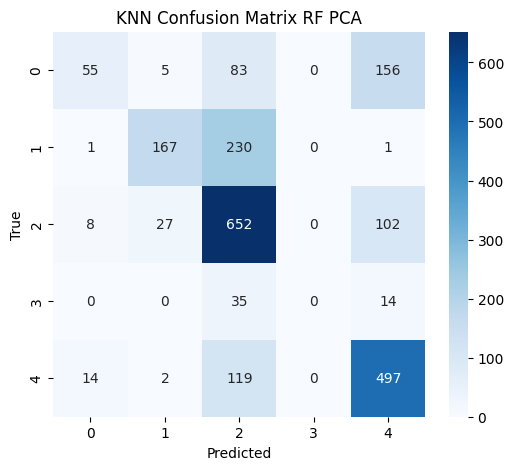

In [26]:
# --- 1) Prepare data ---
# `df` has columns: ['patient_id','epoch_id','label', ... feature columns ...]
id_cols = ['patient_id', 'epoch_id']
label_col = 'label'

label_list ={}
results_list = {}
accuracy_list ={}
for i, df in enumerate(df_list):
    # Separate out IDs and target
    ids    = df[id_cols]
    y      = df[label_col]
    X_full = df.drop(columns=id_cols + [label_col])

    # --- 2) Drop highly correlated features ---
    def drop_high_corr(X, threshold=0.95):
        corr = X.corr().abs()
        np.fill_diagonal(corr.values, 0)
        to_drop = [col for col in corr.columns if any(corr[col] > threshold)]
        print(f"Dropping {len(to_drop)} features with |corr| > {threshold}:")
        print(to_drop)
        return X.drop(columns=to_drop)

    X_uncorr = drop_high_corr(X_full, threshold=0.95)

    # For now we'll just proceed with X_uncorr:
    X_processed = pd.concat([ids.reset_index(drop=True), y.reset_index(drop=True), X_uncorr], axis=1)

    # Split based on patient_id
    train_patients = [1, 2, 3, 4, 5, 6, 7, 8]
    test_patients  = [9, 10]

    # Create train/test sets
    train_df = X_processed[X_processed['patient_id'].isin(train_patients)]
    test_df  = X_processed[X_processed['patient_id'].isin(test_patients)]

    # Extract features and labels
    X_train = train_df.drop(columns=id_cols + [label_col])
    y_train = train_df['label']
    X_test  = test_df.drop(columns=id_cols + [label_col])
    y_test  = test_df['label']

    # 5) K-Nearest Neighbors
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)

    if name_list[i] == 'RF no PCA' or name_list[i] =='RF PCA':
    # --- 5) Train Random Forest ---
        rf = RandomForestClassifier(
            n_estimators=200,
            max_depth=None,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X_train, y_train)
        y_pred_knn = rf.predict(X_test) # Sketchy code but for the plot

    # --- 6) Evaluate ---
    results_list[name_list[i]] = y_pred_knn
    label_list [name_list[i]] = y_test

    print("\n=== Classification Report ===")
    print(classification_report(y_test, y_pred_knn))
    print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
    accuracy_list[name_list[i]] = accuracy_score(y_test, y_pred_knn)

    cm = confusion_matrix(y_test, y_pred_knn)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('KNN Confusion Matrix ' + name_list[i])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


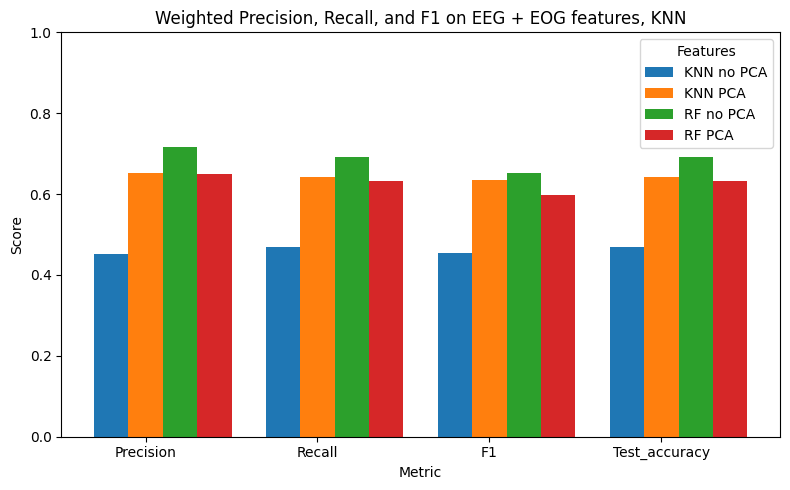

In [27]:
# Compare the evolution of performance when adding new signal features
# 1) Compute weighted metrics for each model


model_preds = results_list

metrics = ['precision', 'recall', 'f1', 'test_accuracy']
results = {}
for name, preds in model_preds.items():
    results[name] = [
        precision_score(label_list[name], preds, average='weighted'),
        recall_score(   label_list[name], preds, average='weighted'),
        f1_score(       label_list[name], preds, average='weighted'),
        accuracy_list[name]
    ]

# 2) Prepare for plotting
labels = [m.capitalize() for m in metrics]
x = np.arange(len(labels))
width = 0.2  # width of each bar

# 3) Create grouped bar chart
plt.figure(figsize=(8, 5))
for i, (df, scores) in enumerate(results.items()):
    plt.bar(x + (i - 1)*width, scores, width, label=df)

# 4) Labels and legend
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Weighted Precision, Recall, and F1 on EEG + EOG features, KNN')
plt.legend(title='Features')
plt.tight_layout()
plt.show()

# K-fold cross validation

In [29]:
from sklearn.model_selection import StratifiedKFold

In [30]:
# Load create the dataframes decribed above
EEG_col = [col for col in df_no_AR.columns if 'EEG' in col]
EOG_col = [col for col in df_no_AR.columns if 'EOG' in col]
ECG_col = [col for col in df_no_AR.columns if 'ECG' in col]

df = df_no_AR.drop(columns=ECG_col)    # Contains EEG ICA cleaned signal & EOG signal features

In [31]:
id_cols = ['patient_id', 'epoch_id']
label_col = 'label'

# Separate labels and features
ids = df[id_cols]
y = df[label_col]
X_full = df.drop(columns=id_cols + [label_col])

# Drop highly correlated features
def drop_high_corr(X, threshold=0.95):
    corr = X.corr().abs()
    np.fill_diagonal(corr.values, 0)
    to_drop = [col for col in corr.columns if any(corr[col] > threshold)]
    print(f"Dropping {len(to_drop)} features with |corr| > {threshold}:")
    return X.drop(columns=to_drop)

X_uncorr = drop_high_corr(X_full, threshold=0.95)
X_processed = pd.concat([ids.reset_index(drop=True), y.reset_index(drop=True), X_uncorr], axis=1)

# --- Leave-One-Patient-Out Cross-Validation ---
unique_patients = sorted(df['patient_id'].unique())
all_reports = []
accuracies = []

for pid in unique_patients:
    train_df = X_processed[X_processed['patient_id'] != pid]
    test_df  = X_processed[X_processed['patient_id'] == pid]

    # Oversampling
    # Separate majority and minority classes
    majority_class = train_df['label'].value_counts().idxmax()
    max_count = train_df['label'].value_counts().max()

    # Create a list to store upsampled DataFrames
    df_upsampled = []

    # Loop over each class
    for label in train_df['label'].unique():
        class_df = train_df[train_df['label'] == label]
        if len(class_df) < max_count:
            class_upsampled = resample(class_df,
                                    replace=True,               # sample with replacement
                                    n_samples=max_count,        # match majority class
                                    random_state=42)
            df_upsampled.append(class_upsampled)
        else:
            df_upsampled.append(class_df)  # keep majority class as is

    # Combine all classes back together
    train_df = pd.concat(df_upsampled).sample(frac=1, random_state=42).reset_index(drop=True)

    # Show class distribution
    print("Balanced class distribution:")
    print(train_df['label'].value_counts())

    X_train = train_df.drop(columns=id_cols + [label_col])
    y_train = train_df[label_col]
    X_test = test_df.drop(columns=id_cols + [label_col])
    y_test = test_df[label_col]

    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    report = classification_report(y_test, y_pred, output_dict=True)
    all_reports.append(report)

    print(f"\n=== Patient {pid} held out ===")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {acc:.4f}")

# --- Average Results ---
avg_accuracy = np.mean(accuracies)
print(f"\n=== Average LOPO Accuracy across patients: {avg_accuracy:.4f} ===")

# Optional: aggregate precision/recall/f1 across folds
def average_reports(reports):
    avg_metrics = {}
    for label in reports[0].keys():
        if label not in ['accuracy', 'macro avg', 'weighted avg']:  # skip if not a class
            avg_metrics[label] = {}
            for metric in reports[0][label]:
                avg_metrics[label][metric] = np.mean([r[label][metric] for r in reports if label in r])
    return avg_metrics

avg_report = average_reports(all_reports)
print("\n=== Averaged Classification Metrics per Class ===")
for label, metrics in avg_report.items():
    print(f"Class {label}: " + ", ".join([f"{k}={v:.2f}" for k, v in metrics.items()]))

Dropping 16 features with |corr| > 0.95:
Balanced class distribution:
label
0    3351
4    3351
3    3351
2    3351
1    3351
Name: count, dtype: int64

=== Patient 1 held out ===
              precision    recall  f1-score   support

           0       0.85      0.73      0.78       102
           1       0.86      0.54      0.67       145
           2       0.75      0.85      0.80       457
           3       0.00      0.00      0.00        47
           4       0.76      0.88      0.81       332

    accuracy                           0.77      1083
   macro avg       0.64      0.60      0.61      1083
weighted avg       0.75      0.77      0.75      1083

Accuracy: 0.7701
Balanced class distribution:
label
0    3570
2    3570
4    3570
3    3570
1    3570
Name: count, dtype: int64


c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\U


=== Patient 2 held out ===
              precision    recall  f1-score   support

           0       0.92      0.18      0.30        61
           1       0.47      0.69      0.56        61
           2       0.71      0.74      0.72       238
           3       0.00      0.00      0.00         3
           4       0.96      0.98      0.97       715

    accuracy                           0.86      1078
   macro avg       0.61      0.52      0.51      1078
weighted avg       0.87      0.86      0.85      1078

Accuracy: 0.8590
Balanced class distribution:
label
4    3519
0    3519
1    3519
2    3519
3    3519
Name: count, dtype: int64

=== Patient 3 held out ===
              precision    recall  f1-score   support

           0       0.68      0.52      0.59        86
           1       0.89      0.92      0.91       307
           2       0.71      0.76      0.73       289
           3       0.00      0.00      0.00        35
           4       0.86      0.92      0.89       331

 

c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\U


=== Patient 4 held out ===
              precision    recall  f1-score   support

           0       0.63      0.26      0.37        92
           1       0.88      0.70      0.78       315
           2       0.40      0.80      0.53       177
           3       0.00      0.00      0.00        18
           4       0.86      0.73      0.79       272

    accuracy                           0.67       874
   macro avg       0.55      0.50      0.49       874
weighted avg       0.73      0.67      0.67       874

Accuracy: 0.6682
Balanced class distribution:
label
4    3300
3    3300
2    3300
1    3300
0    3300
Name: count, dtype: int64

=== Patient 5 held out ===
              precision    recall  f1-score   support

           0       0.43      0.78      0.56        91
           1       0.71      0.93      0.81        99
           2       0.89      0.77      0.82       508
           3       0.00      0.00      0.00        42
           4       0.85      0.86      0.85       343

 

c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\U


=== Patient 7 held out ===
              precision    recall  f1-score   support

           0       0.63      0.22      0.32       148
           1       0.88      0.57      0.70        40
           2       0.78      0.80      0.79       459
           3       0.00      0.00      0.00        18
           4       0.62      0.91      0.74       253

    accuracy                           0.71       918
   macro avg       0.58      0.50      0.51       918
weighted avg       0.70      0.71      0.68       918

Accuracy: 0.7113
Balanced class distribution:
label
3    3446
0    3446
1    3446
4    3446
2    3446
Name: count, dtype: int64


c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\U


=== Patient 8 held out ===
              precision    recall  f1-score   support

           0       1.00      0.06      0.12        81
           1       0.84      0.94      0.89       213
           2       0.56      0.93      0.70       362
           3       0.00      0.00      0.00        15
           4       0.95      0.38      0.54       287

    accuracy                           0.68       958
   macro avg       0.67      0.46      0.45       958
weighted avg       0.77      0.68      0.63       958

Accuracy: 0.6764
Balanced class distribution:
label
4    3510
1    3510
3    3510
2    3510
0    3510
Name: count, dtype: int64

=== Patient 9 held out ===
              precision    recall  f1-score   support

           0       0.64      0.59      0.61       131
           1       0.72      0.31      0.43       236
           2       0.50      0.89      0.64       298
           3       0.33      0.13      0.19        38
           4       0.96      0.80      0.87       382

 

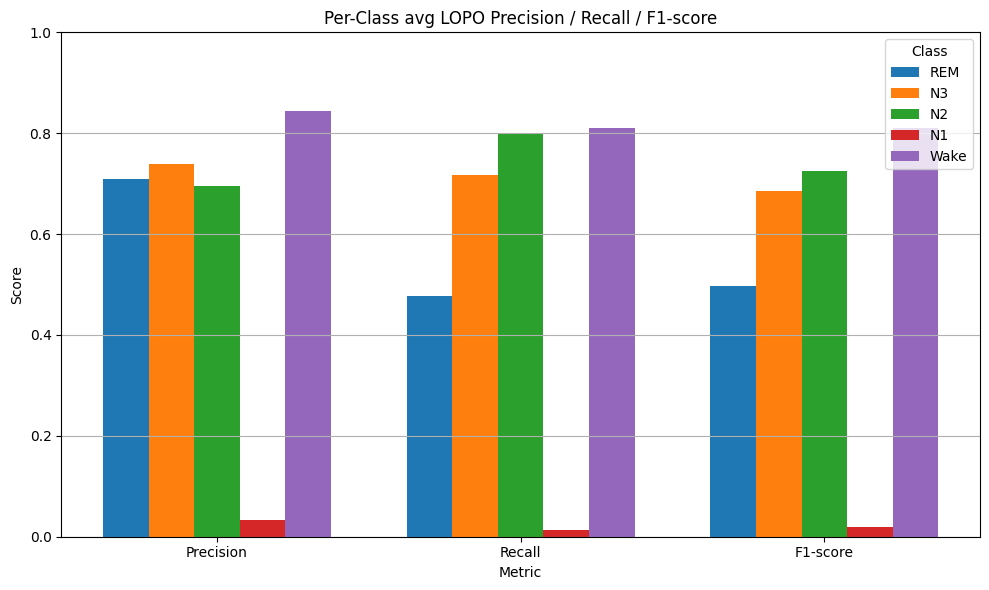


=== Average LOPO Accuracy across patients: 0.7403 ===


In [32]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Plot metric-wise bars for each class ---
class_labels = sorted([int(k) for k in avg_report.keys()])
label_names = ['REM', 'N3', 'N2', 'N1', 'Wake']  # Make sure this matches class_labels order

# Extract per-class values for each metric
precision_vals = [avg_report[str(k)]['precision'] for k in class_labels]
recall_vals    = [avg_report[str(k)]['recall'] for k in class_labels]
f1_vals        = [avg_report[str(k)]['f1-score'] for k in class_labels]

# Prepare data
metrics = ['Precision', 'Recall', 'F1-score']
num_classes = len(class_labels)
x = np.arange(len(metrics))  # 0 = Precision, 1 = Recall, 2 = F1

width = 0.15  # Small width for each class

plt.figure(figsize=(10, 6))

# Plot each class as a bar for each metric
for i, (label, color) in enumerate(zip(label_names, plt.cm.tab10.colors)):
    values = [precision_vals[i], recall_vals[i], f1_vals[i]]
    plt.bar(x + (i - num_classes/2)*width + width/2, values, width=width, label=label, color=color)

# Customize axes
plt.xticks(ticks=x, labels=metrics)
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Per-Class avg LOPO Precision / Recall / F1-score')
plt.ylim(0, 1)
plt.legend(title="Class")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# --- 2. Display average accuracy ---
print(f"\n=== Average LOPO Accuracy across patients: {avg_accuracy:.4f} ===")



# Best Model


=== Fixed Split (1-8 train, 9-10 test) ===
              precision    recall  f1-score   support

           0       0.78      0.61      0.68       299
           1       0.89      0.41      0.57       399
           2       0.65      0.94      0.77       789
           3       0.16      0.12      0.14        49
           4       0.88      0.80      0.84       632

    accuracy                           0.74      2168
   macro avg       0.67      0.58      0.60      2168
weighted avg       0.77      0.74      0.72      2168

Accuracy: 0.7366


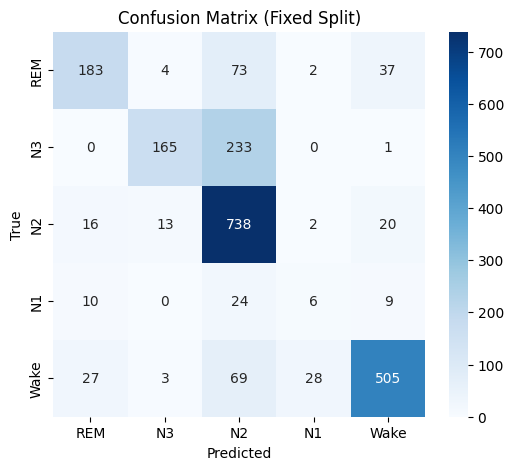

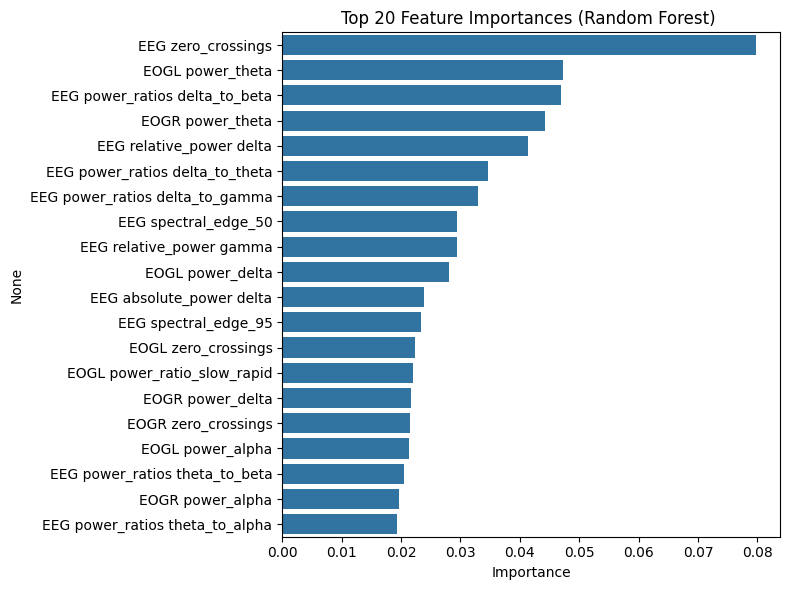

In [33]:
# --- Best Model ---
train_patients = [1, 2, 3, 4, 5, 6, 7, 8]
test_patients  = [9, 10]

train_df = X_processed[X_processed['patient_id'].isin(train_patients)]
test_df  = X_processed[X_processed['patient_id'].isin(test_patients)]

# Oversampling
# Separate majority and minority classes
majority_class = train_df['label'].value_counts().idxmax()
max_count = train_df['label'].value_counts().max()

# Create a list to store upsampled DataFrames
df_upsampled = []

# Loop over each class
for label in train_df['label'].unique():
    class_df = train_df[train_df['label'] == label]
    if len(class_df) < max_count:
        class_upsampled = resample(class_df,
                                replace=True,               # sample with replacement
                                n_samples=max_count,        # match majority class
                                random_state=42)
        df_upsampled.append(class_upsampled)
    else:
        df_upsampled.append(class_df)  # keep majority class as is

# Combine all classes back together
train_df = pd.concat(df_upsampled).sample(frac=1, random_state=42).reset_index(drop=True)

X_train = train_df.drop(columns=id_cols + [label_col])
y_train = train_df[label_col]
X_test  = test_df.drop(columns=id_cols + [label_col])
y_test  = test_df[label_col]

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\n=== Fixed Split (1-8 train, 9-10 test) ===")
print(classification_report(y_test, y_pred_rf))
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")

# Confusion matrix
label_names = ["REM", "N3", "N2", "N1", "Wake"]
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix (Fixed Split)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 7) Feature importances 
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False).head(20)
plt.figure(figsize=(8,6))
sns.barplot(x=importances.values, y=importances.index, orient='h')
plt.title('Top 20 Feature Importances (Random Forest) ')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

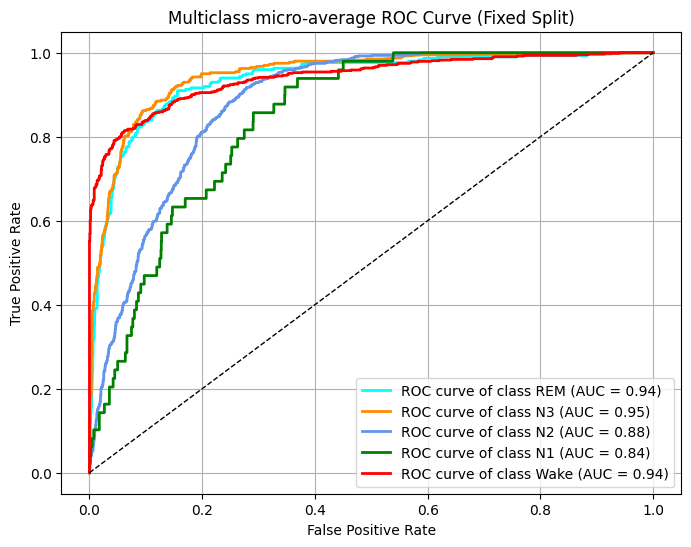

In [34]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder
from itertools import cycle

# Binarize the labels
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)
y_pred_proba = rf.predict_proba(X_test)

# Binarize true and predicted labels for ROC
y_test_bin = label_binarize(y_test_encoded, classes=range(len(label_names)))
# y_pred_proba is already suitable shape: (n_samples, n_classes)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(label_names)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
for i, color in zip(range(len(label_names)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {label_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass micro-average ROC Curve (Fixed Split)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()